# PythonJob
## Introduction

The `PythonJob` is a built-in task that allows users to run Python functions on a remote computer. It is designed to enable users from non-AiiDA communities to run their Python functions remotely and construct workflows with checkpoints, maintaining all data provenance. For instance, users can use ASE's calculator to run a DFT calculation on a remote computer directly. Users only need to write normal Python code, and the WorkGraph will handle the data transformation to AiiDA data.

### Key Features

1. **Remote Execution**: Seamlessly run Python functions on a remote computer.
2. **User-Friendly**: Designed for users who are not familiar with AiiDA, simplifying the process of remote execution.
3. **Workflow Management**: Construct workflows with checkpoints, ensuring that intermediate states and results are preserved.
4. **Data Provenance**: Maintain comprehensive data provenance, tracking the full history and transformations of data.


Load the AiiDA profile.

In [8]:
%load_ext aiida
from aiida import load_profile
load_profile()

Profile<uuid='57ccbf7d9e2b41b39edb2bfdaf725feb' name='default'>

## First Workflow
Suppose you need to calculate `(x + y) * z` in two steps: first, add `x` and `y`; second, multiply the result by `z`.

There are three methods to declare a `PythonJob` task in a workflow:

1. **Using the `task.pythonjob` decorator:** Apply this decorator directly when you define the function. This method is straightforward and integrates the task declaration seamlessly with function definition.

2. **Converting an existing function with `task.pythonjob`:** If the function is already defined, you can convert it into a `PythonJob` task by wrapping it with the `task.pythonjob` decorator. This approach is useful when adapting pre-existing code into a task-based workflow.

3. **Specifying `PythonJob` during task addition to the WorkGraph:** When adding a task to the WorkGraph, you can explicitly identify it as a `PythonJob`. This method offers flexibility, allowing you to dynamically assign the task type based on the workflow design requirements.


In [2]:
from aiida_workgraph import WorkGraph, task

# decorator to define a pythonjob
@task.pythonjob()
def add(x, y):
    return x + y


# here is a normal python function
def multiply(x, y):
    return x*y

wg = WorkGraph("first_workflow")
wg.add_task(add, name="add")
# we can also use a normal python function directly, but provide the "PythonJob" as the first argument
wg.add_task("PythonJob", function=multiply, name="multiply", x=wg.tasks["add"].outputs[0])

# visualize the workgraph
wg.to_html()
# visualize the workgraph in jupyter-notebook
# wg

### Prepare the inputs and submit the workgraph


**Code**: We can set the `computer` to the remote computer where we want to run the job. This will create a code `python3@computer` if it does not already exist. You can also set the `code` directly if you have already created the code.

**Data**: Users are recommended to use normal Python data as input. The workgraph will handle the transfer and serialization of data to AiiDA data. When serializing to AiiDA data, the workgraph will first search for the corresponding AiiDA data entry point based on the module name and class name (e.g., `ase.atoms.Atoms`). If the corresponding entry point exists, it will be used to serialize the value. If not found, `GeneralData` (pickle) will be used to serialize the value into binary data.

**Python Version**: Since pickle is used to store and load data, the Python version on the remote computer should match the one used on the localhost. You can use conda to create a virtual environment with the same Python version. Activate the environment before running the script.

For real applications, you can pass metadata to the scheduler to activate the conda environment:

```python
metadata = {
    "options": {
        'custom_scheduler_commands': 'module load anaconda\nconda activate py3.11\n',
    }
}
```

#### Create a conda environment on the remote computer
One can use the `create_conda_env` function to create a conda environment on the remote computer. The function will create a conda environment with the specified packages and modules. The function will update the packages if the environment already exists.

```python
from aiida_workgraph.utils import create_conda_env
# create a conda environment on remote computer
create_conda_env("merlin6", "test_pythonjob", modules=["anaconda"],
                 pip=["numpy", "matplotlib"],
                 conda={"channels": ["conda-forge"],
                        "dependencies": ["qe"]},
                )
```

WorkGraph process created, PK: 151133

Result of multiply is uuid: ffd35a52-a7c3-4675-adba-a2108cc242cd (pk: 151154) value: 20 




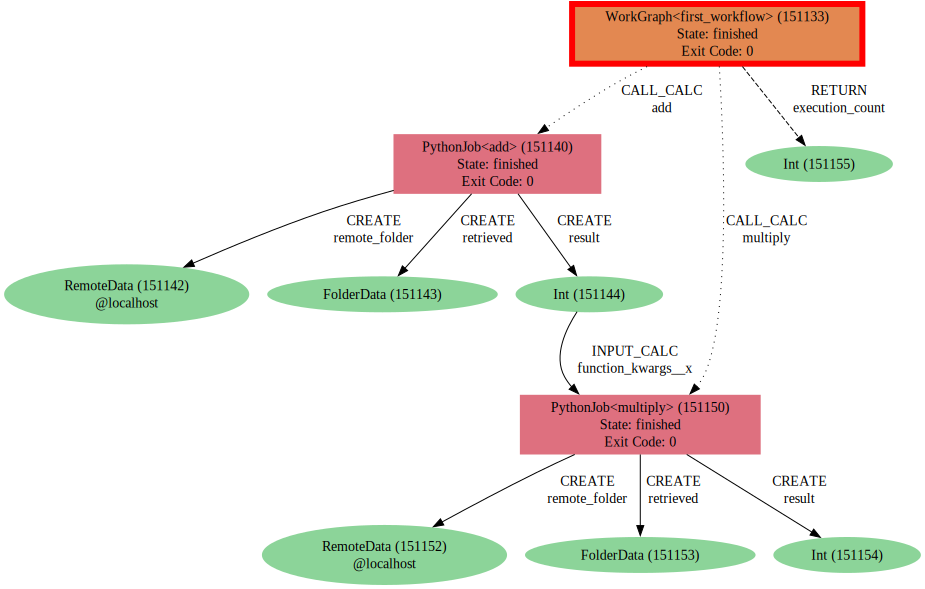

In [3]:
from aiida_workgraph.utils import generate_node_graph

#------------------------- Submit the calculation -------------------
# For real applications, one can pass metadata to the scheduler to activate the conda environment
metadata = {
    "options": {
        # 'custom_scheduler_commands' : 'module load anaconda\nconda activate py3.11\n',
        'custom_scheduler_commands' : '',
    }
}

wg.submit(inputs = {"add": {"x": 2, "y": 3,
                            "computer": "localhost",
                            "metadata": metadata},
                    "multiply": {"y": 4,
                                 "computer": "localhost",
                                 "metadata": metadata}},
          wait=True)
#------------------------- Print the output -------------------------
print("\nResult of multiply is {} \n\n".format(wg.tasks["multiply"].outputs['result'].value))
#------------------------- Generate node graph -------------------
generate_node_graph(wg.pk)

## Use parent folder
The parent_folder parameter allows a task to access the output files of a parent task. This feature is particularly useful when you want to reuse data generated by a previous computation in subsequent computations. In the following example, the multiply task uses the `result.txt` file created by the add task.


In [4]:
from aiida_workgraph import WorkGraph, task

def add(x, y):
    z = x + y
    with open("result.txt", "w") as f:
        f.write(str(z))

def multiply(x, y):
    with open("parent_folder/result.txt", "r") as f:
        z = int(f.read())
    return x*y + z

wg = WorkGraph("PythonJob_parent_folder")
wg.add_task("PythonJob", function=add, name="add")
wg.add_task("PythonJob", function=multiply, name="multiply",
             parent_folder=wg.tasks["add"].outputs["remote_folder"],
             )

wg.to_html()

Submit the workgraph and print the result.

In [5]:
wg.submit(inputs = {"add": {"x": 2, "y": 3, "computer": "localhost"},
                    "multiply": {"x": 3, "y": 4, "computer": "localhost"}},
          wait=True)
print("\nResult of multiply is {} \n\n".format(wg.tasks["multiply"].outputs['result'].value))

WorkGraph process created, PK: 151156

Result of multiply is uuid: 0849fb0a-d461-4a08-8e73-89fb4f848d59 (pk: 151178) value: 17 




## Upload files or folders to the remote computer
The `upload_files` parameter allows users to upload files or folders to the remote computer. The files will be uploaded to the working directory of the remote computer.



In [6]:
from aiida_workgraph import WorkGraph, task

# create a temporary file "input.txt" in the current directory
with open("input.txt", "w") as f:
    f.write("2")

# create a temporary folder "inputs_folder" in the current directory
# and add a file "another_input.txt" in the folder
import os
os.makedirs("inputs_folder", exist_ok=True)
with open("inputs_folder/another_input.txt", "w") as f:
    f.write("3")

def add():
    with open("input.txt", "r") as f:
        a = int(f.read())
    with open("inputs_folder/another_input.txt", "r") as f:
        b = int(f.read())
    return a + b


wg = WorkGraph("PythonJob_upload_files")
wg.add_task("PythonJob", function=add, name="add")

#------------------------- Submit the calculation -------------------
# we need use full path to the file
input_file = os.path.abspath("input.txt")
input_folder = os.path.abspath("inputs_folder")

wg.submit(inputs = {"add": {
                            "computer": "localhost",
                            "upload_files": {"input.txt": input_file,
                                             "inputs_folder": input_folder,
                                             },
                            },
                    },
          wait=True)
print("\nResult of add is {} \n\n".format(wg.tasks["add"].outputs['result'].value))

WorkGraph process created, PK: 151180

Result of add is uuid: 14393adc-ddfd-4b2a-8754-d7d785a8c3e0 (pk: 151191) value: 5 




## First Real-world Workflow: atomization energy of molecule

The atomization energy, $\Delta E$, of a molecule can be expressed as:

$$
\Delta E = n_{\text{atom}} \times E_{\text{atom}} - E_{\text{molecule}}
$$

Where:
- $\Delta E$ is the atomization energy of the molecule.
- $n_{\text{atom}}$ is the number of atoms.
- $E_{\text{atom}}$ is the energy of an isolated atom.
- $E_{\text{molecule}}$ is the energy of the molecule.


### Define a task to calculate the energy of the atoms using EMT potential

In [7]:
from aiida_workgraph import task, WorkGraph

def emt(atoms):
    from ase.calculators.emt import EMT
    atoms.calc = EMT()
    energy = atoms.get_potential_energy()
    return energy


def atomization_energy(mol, energy_molecule, energy_atom):
    energy = energy_atom*len(mol) - energy_molecule
    return energy


### Define a workgraph


In [8]:
wg = WorkGraph("atomization_energy")
pw_atom = wg.add_task("PythonJob", function=emt, name="emt_atom")
pw_mol = wg.add_task("PythonJob", function=emt, name="emt_mol")
wg.add_task("PythonJob", function=atomization_energy, name="atomization_energy",
             energy_atom=pw_atom.outputs["result"],
             energy_molecule=pw_mol.outputs["result"])
wg.to_html()

### Prepare the inputs and submit the workflow

WorkGraph process created, PK: 151193
Energy of a N atom:                  5.100
Energy of an un-relaxed N2 molecule: 0.549
Atomization energy:                  9.651 eV


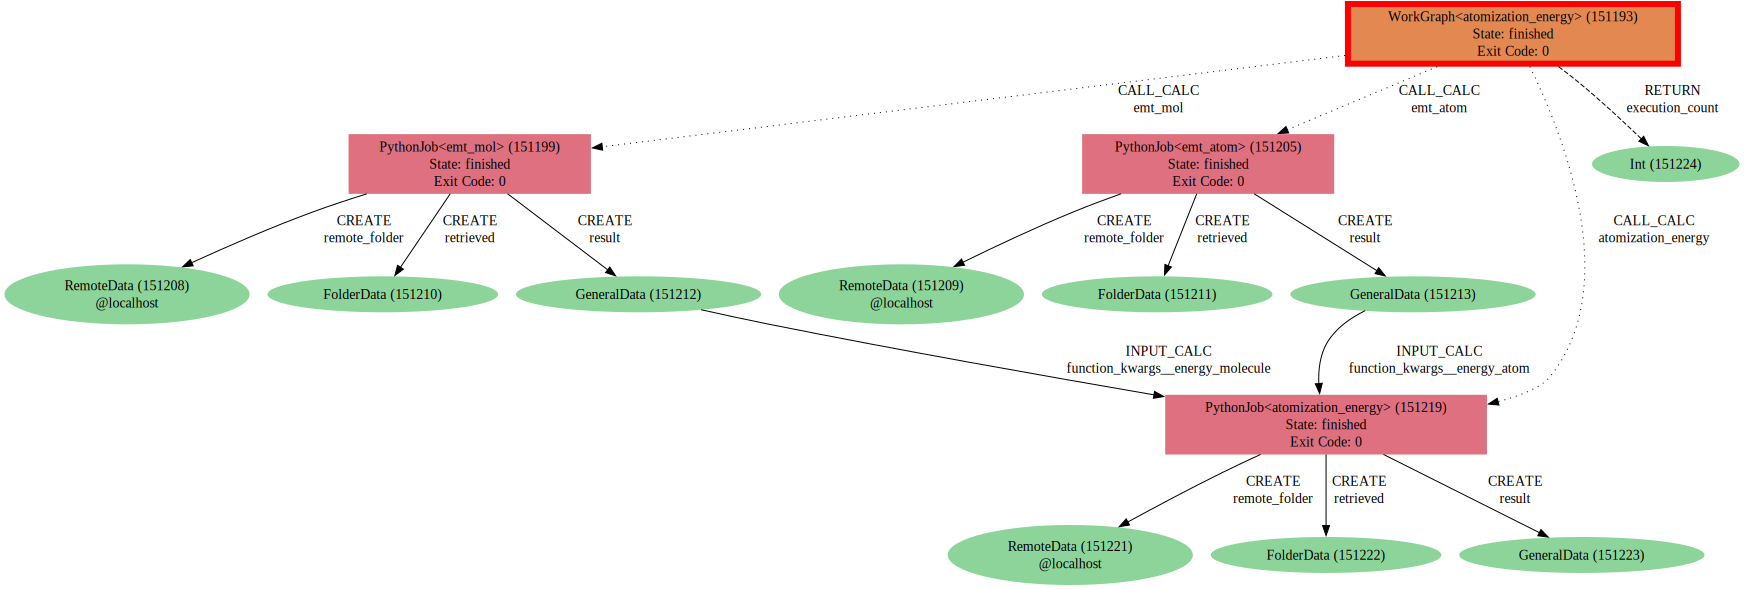

In [9]:
from ase.build import molecule
from ase import Atoms

load_profile()

# create input structure
n_atom = Atoms("N", pbc=True)
n_atom.center(vacuum=5.0)
n2_molecule = molecule("N2", pbc=True)
n2_molecule.center(vacuum=5.0)


#------------------------- Set the inputs -------------------------
wg.tasks["emt_atom"].set({"atoms": n_atom, "computer": "localhost"})
wg.tasks["emt_mol"].set({"atoms": n2_molecule, "computer": "localhost"})
wg.tasks["atomization_energy"].set({"mol": n2_molecule, "computer": "localhost"})
#------------------------- Submit the calculation -------------------
wg.submit(wait=True, timeout=200)
#------------------------- Print the output -------------------------
print('Energy of a N atom:                  {:0.3f}'.format(wg.tasks['emt_atom'].outputs["result"].value.value))
print('Energy of an un-relaxed N2 molecule: {:0.3f}'.format(wg.tasks['emt_mol'].outputs["result"].value.value))
print('Atomization energy:                  {:0.3f} eV'.format(wg.tasks['atomization_energy'].outputs["result"].value.value))
#------------------------- Generate node graph -------------------
generate_node_graph(wg.pk)


## Call shell commands in the PythonJob task

We want to calculate `(x+y)*z` in two steps using `echo` and `bc` commands.

Step 1: Calculate (x+y) and store it as result
```
result=$(echo "$x + $y" | bc)
```

Step 2: Multiply result by z and store the final result
```
result=$(echo "$result * $z" | bc)
```

If one wanted to run this workflow in AiiDA, one would have to write plugins for `echo` and `bc` commands, and a WorkChain to handle the workflow. With aiida-workgraph and the `PythonJob` task, this can be run through AiiDA with the following workgraph:

In [10]:
from aiida_workgraph import task, WorkGraph

def add(x, y):
    import os
    os.system("echo '{} + {}' | bc > result.txt".format(x, y))
    with open("result.txt", "r") as f:
        return float(f.read())


def multiply(x, y):
    import os
    os.system("echo '{} * {}' | bc > result.txt".format(x, y))
    with open("result.txt", "r") as f:
        return float(f.read())


wg = WorkGraph("PythonJob_shell_command")
wg.add_task("PythonJob", function=add, name="add")
wg.add_task("PythonJob", function=multiply, name="multiply", x=wg.tasks["add"].outputs[0])

# visualize the workgraph
wg.to_html()


submit the workgraph and print the result:

WorkGraph process created, PK: 151225

Result of multiply is uuid: deab3241-85b3-47d6-9551-9d8d14dc255d (pk: 151246) value: 20.0 




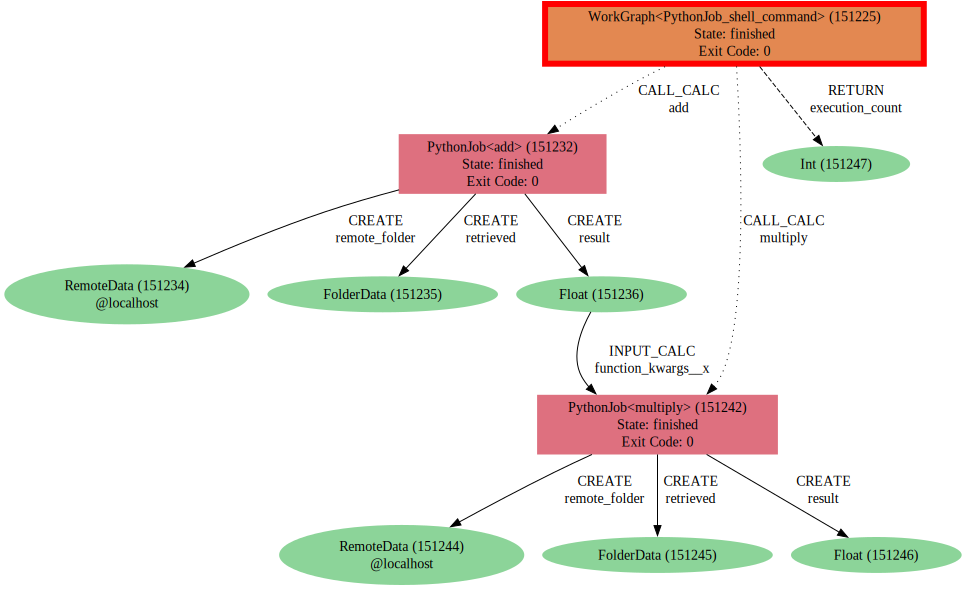

In [11]:

wg.submit(inputs = {"add": {"x": 2, "y": 3, "computer": "localhost"},
                    "multiply": {"y": 4, "computer": "localhost"}},
          wait=True)
#------------------------- Print the output -------------------------
print("\nResult of multiply is {} \n\n".format(wg.tasks["multiply"].outputs['result'].value))
#------------------------- Generate node graph -------------------
generate_node_graph(wg.pk)

## Note
One can not run a `graph_builder` task in a `PythonJob` task. The `graph_builder` task is used to build the workgraph, and it should be run in the localhost by the daemon.

However, one can run a `PythonJob` task in a `graph_builder` task. The `PythonJob` task will be executed on the remote computer.

The following code will raise an error:

```python
from aiida_workgraph import task, WorkGraph


@task.graph_builder()
def add_multiply():
    wg = WorkGraph()
    return wg

wg = WorkGraph()
wg.add_task("PythonJob", function=add_multiply, name="add_multiply")

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
/tmp/ipykernel_3498848/1351840398.py in <cell line: 0>()
      8 
      9 wg = WorkGraph()
---> 10 wg.add_task("PythonJob", function=add_multiply, name="add_multiply")

~/repos/superstar54/aiida-workgraph/aiida_workgraph/collection.py in new(self, identifier, name, uuid, run_remotely, **kwargs)
     35             return super().new(identifier, name, uuid, **kwargs)
     36         if isinstance(identifier, str) and identifier.upper() == "PYTHONJOB":
---> 37             identifier, _ = build_pythonjob_task(kwargs.pop("function"))
     38             return super().new(identifier, name, uuid, **kwargs)
     39         if isinstance(identifier, str) and identifier.upper() == "SHELLJOB":

~/repos/superstar54/aiida-workgraph/aiida_workgraph/decorator.py in build_pythonjob_task(func)
    262 
    263     if func.node.node_type.upper() == "GRAPH_BUILDER":
--> 264         raise ValueError(
    265             "GraphBuilder task cannot be run remotely. Please remove 'PythonJob'."
    266         )

ValueError: GraphBuilder task cannot be run remotely. Please remove 'PythonJob'.
```

However, the following code will work:

In [12]:
from aiida_workgraph import task, WorkGraph


@task.graph_builder()
def add_multiply():
    wg = WorkGraph()
    wg.add_task("PythonJob", function=add, name="add")
    return wg

wg = WorkGraph()
wg.add_task(add_multiply, name="add_multiply")

NodeGraphWidget(settings={'minmap': False}, style={'width': '80%', 'height': '600px'}, value={'name': 'add_mul…

### Using `parent_folder_name` for Data Continuity

AiiDA runs each job in a separate folder. If one calculation requires data from previous calculations to be accessible in the current job's working directory. This has been managed with the `parent_folder` input, which specifies a source for copying necessary data. The new `parent_folder_name` input streamlines this process by allowing users to define a subfolder within the working directory to organize these files effectively.

#### Example Usage: NSCF Calculation
In the context of an NSCF calculation, where data dependency exists on outputs from a SCF calculation, the workflow can be configured as follows:

```python
nscf_task = wg.add_task("PythonJob",
    function=pw_calculator,
    name="nscf",
    parent_folder=scf_task.outputs["remote_folder"],
    parent_output_folder="out",
    parent_folder_name="out",
)
```
This setup will copy all content of the `out` folder from the SCF calculation's remote folder into an `out` folder within the working directory of the NSCF job.

### Handling Multiple Data Sources with `copy_files`
The traditional `parent_folder` method is limited when calculations require inputs from multiple remote directories. For instance, Bader charge analysis with Quantum ESPRESSO may need both valence and all-electron density data from different calculations.

The new `copy_files` input allows for flexible linkage to multiple remote folders. It facilitates copying necessary files from diverse sources into a single job's directory under dynamically generated subfolder names based on taskand socket names.

#### Example Usage: Bader Charge Analysis
For a Bader analysis requiring different charge density files:

```python
bader_task = wg.add_task("PythonJob",
    function=bader_calculator,
    name="bader",
    command=bader_command,
    charge_density_folder="pp_valence_remote_folder",
    reference_charge_density_folder="pp_all_remote_folder",
)
wg.add_link(pp_valence.outputs["remote_folder"], bader_task.inputs["copy_files"])
wg.add_link(pp_all.outputs["remote_folder"], bader_task.inputs["copy_files"])
```

The `bader_calculator` function using specified charge density data:

```python
def bader_calculator(
    command: str = "pw.x",
    charge_density_folder: str = "./",
    charge_density_filename: str = "charge_density.cube",
    reference_charge_density_folder: str = "./",
    reference_charge_density_filename: str = "charge_density.cube",
):
    """Run Bader charge analysis."""
    command_str = f"{command} {charge_density_folder}/{charge_density_filename}"
    if reference_charge_density_filename:
        command_str += f" -ref {reference_charge_density_folder}/{reference_charge_density_filename}"
    os.system(command_str)

    with open("ACF.dat", "r") as f:
        lines = f.readlines()
        charges = [float(line.split()[4]) for line in lines[2:-4]]

    return charges
```


## Namespace Output

The `PythonJob` allows users to define namespace outputs. A namespace output is a dictionary with keys and values returned by a function. Each value in this dictionary will be serialized to AiiDA data, and the key-value pair will be stored in the database.

### Why Use Namespace Outputs?

- **Dynamic and Flexible**: The keys and values in the namespace output are not fixed and can change based on the task's execution.
- **Querying**: The data in the namespace output is stored as an AiiDA data node, allowing for easy querying and retrieval.
- **Data Provenance**: When the data is used as input for subsequent tasks, the origin of data is tracked.

### Example Use Case

Consider a molecule adsorption calculation where the namespace output stores the surface slabs of the molecule adsorbed on different surface sites. The number of surface slabs can vary depending on the surface. These output surface slabs can be utilized as input to the next task to calculate the energy.

### Defining Namespace Outputs

To declare a namespace output, set the `identifier` to `workgraph.namespace` in the `outputs` parameter of the `@task` decorator. For example:

```python
@task(outputs=[{"name": "structures", "identifier": "workgraph.namespace"}])
def generate_surface_slabs():
    # Function logic to generate surface slabs
    return {"slab1": slab_data1, "slab2": slab_data2}
```


One can also define nested namespace outputs by specifying the `identifier` as `workgraph.namespace` for sub-dictionaries within the namespace output. For example, here we define `add_multiply.add` as a nested namespace output:

```python
@task(
    outputs=[{"name": "add_multiply", "identifier": "workgraph.namespace"},
             {"name": "add_multiply.add", "identifier": "workgraph.namespace"},
             {"name": "minus"},
    ]
)
def myfunc(x, y):
    add = {"order1": x + y, "order2": x * x + y * y}
    return {
        "add_multiply": {"add": add, "multiply": x * y},
        "minus": x - y,
    }
```


### Using Namespace Outputs as Inputs

A namespace output can be passed directly as an input to another task. It will be passed as a dictionary to the task, preserving the structure and allowing for flexible data handling.

If you want to pass the value of a key in the namespace output as an input to another task, you need to define a output for that key. For example, to pass the value of `add_multiply.add` as an input to another task, you need to define an output for `add_multiply.add`:

```python
@task(
    outputs=[
        {"identifier": "workgraph.namespace", "name": "add_multiply"},
        {"name": "add_multiply.add"},
        {"name": "add_multiply.multiply"},
        {"name": "minus"},
    ]
)
def myfunc(x, y):
    return {
        "add_multiply": {"add": x + y, "multiply": x * y},
        "minus": x - y,
    }
```

then you can pass the value of `add_multiply.add` as an input to another task:

```python
wg.add_task("PythonJob",
        function=myfunc3,
        name="myfunc3",
        x=wg.tasks["myfunc"].outputs["add_multiply.add"],
    )
```


## Second Real-world Workflow: Equation of state (EOS) WorkGraph



In [15]:
from aiida_workgraph import WorkGraph, task
from ase.build import bulk
from ase import Atoms
from aiida import load_profile

load_profile()

@task(outputs=[{"name": "scaled_atoms", "identifier": "workgraph.namespace"},
               {"name": "volumes"}]
)
def generate_scaled_atoms(atoms: Atoms, scales: list) -> dict:
    """Scale the structure by the given scales."""
    volumes = {}
    scaled_atoms = {}
    for i in range(len(scales)):
        atoms1 = atoms.copy()
        atoms1.set_cell(atoms.cell * scales[i], scale_atoms=True)
        scaled_atoms[f"s_{i}"] = atoms1
        volumes[f"s_{i}"] = atoms1.get_volume()
    return {"scaled_atoms": scaled_atoms, "volumes": volumes}

@task()
def emt(atoms):
    from ase.calculators.emt import EMT
    atoms.calc = EMT()
    energy = atoms.get_potential_energy()
    return {"energy": energy}

# Output result from context to the output socket
@task.graph_builder(outputs=[{"name": "results", "from": "context.results"}])
def calculate_enegies(scaled_atoms):
    """Run the scf calculation for each structure."""
    from aiida_workgraph import WorkGraph
    wg = WorkGraph()
    for key, atoms in scaled_atoms.items():
        emt1 = wg.add_task("PythonJob", function=emt, name=f"emt1_{key}", atoms=atoms)
        emt1.set({"computer": "localhost"})
        # save the output parameters to the context
        emt1.set_context({"result": f"results.{key}"})
    return wg


@task()
def fit_eos(volumes: dict, emt_results: dict) -> dict:
    """Fit the EOS of the data."""
    from ase.eos import EquationOfState
    from ase.units import kJ

    volumes_list = []
    energies = []
    for key, data in emt_results.items():
        energy = data["energy"]
        energies.append(energy)
        volumes_list.append(volumes[key])
    #
    eos = EquationOfState(volumes_list, energies)
    v0, e0, B = eos.fit()
    # convert B to GPa
    B = B / kJ * 1.0e24
    eos = {"energy unit": "eV", "v0": v0, "e0": e0, "B": B}
    return eos

atoms = bulk("Au", cubic=True)

wg = WorkGraph("pythonjob_eos_emt")
scale_atoms_task = wg.add_task("PythonJob",
        function=generate_scaled_atoms,
        name="scale_atoms",
        atoms=atoms,
    )
    # -------- calculate_enegies -----------
calculate_enegies_task = wg.add_task(calculate_enegies,
        name="calculate_enegies",
        scaled_atoms=scale_atoms_task.outputs["scaled_atoms"],
    )
    # -------- fit_eos -----------
wg.add_task("PythonJob",
        function=fit_eos,
        name="fit_eos",
        volumes=scale_atoms_task.outputs["volumes"],
        emt_results=calculate_enegies_task.outputs["results"],
    )
wg.to_html()

In [16]:


wg.submit(
          inputs={"scale_atoms": {"atoms": atoms,
                                  "scales": [0.95, 1.0, 1.05],
                                  "computer": "localhost"},
                    "fit_eos": {"computer": "localhost"}},
          wait=True,
          )

print("The fitted EOS parameters are:")
wg.tasks["fit_eos"].outputs["result"].value.value


WorkGraph process created, PK: 151263
The fitted EOS parameters are:


{'B': 167.61300824791,
 'e0': 0.006458727465855,
 'v0': 67.197735262521,
 'energy unit': 'eV'}

Generate the node graph and check the data provenance.

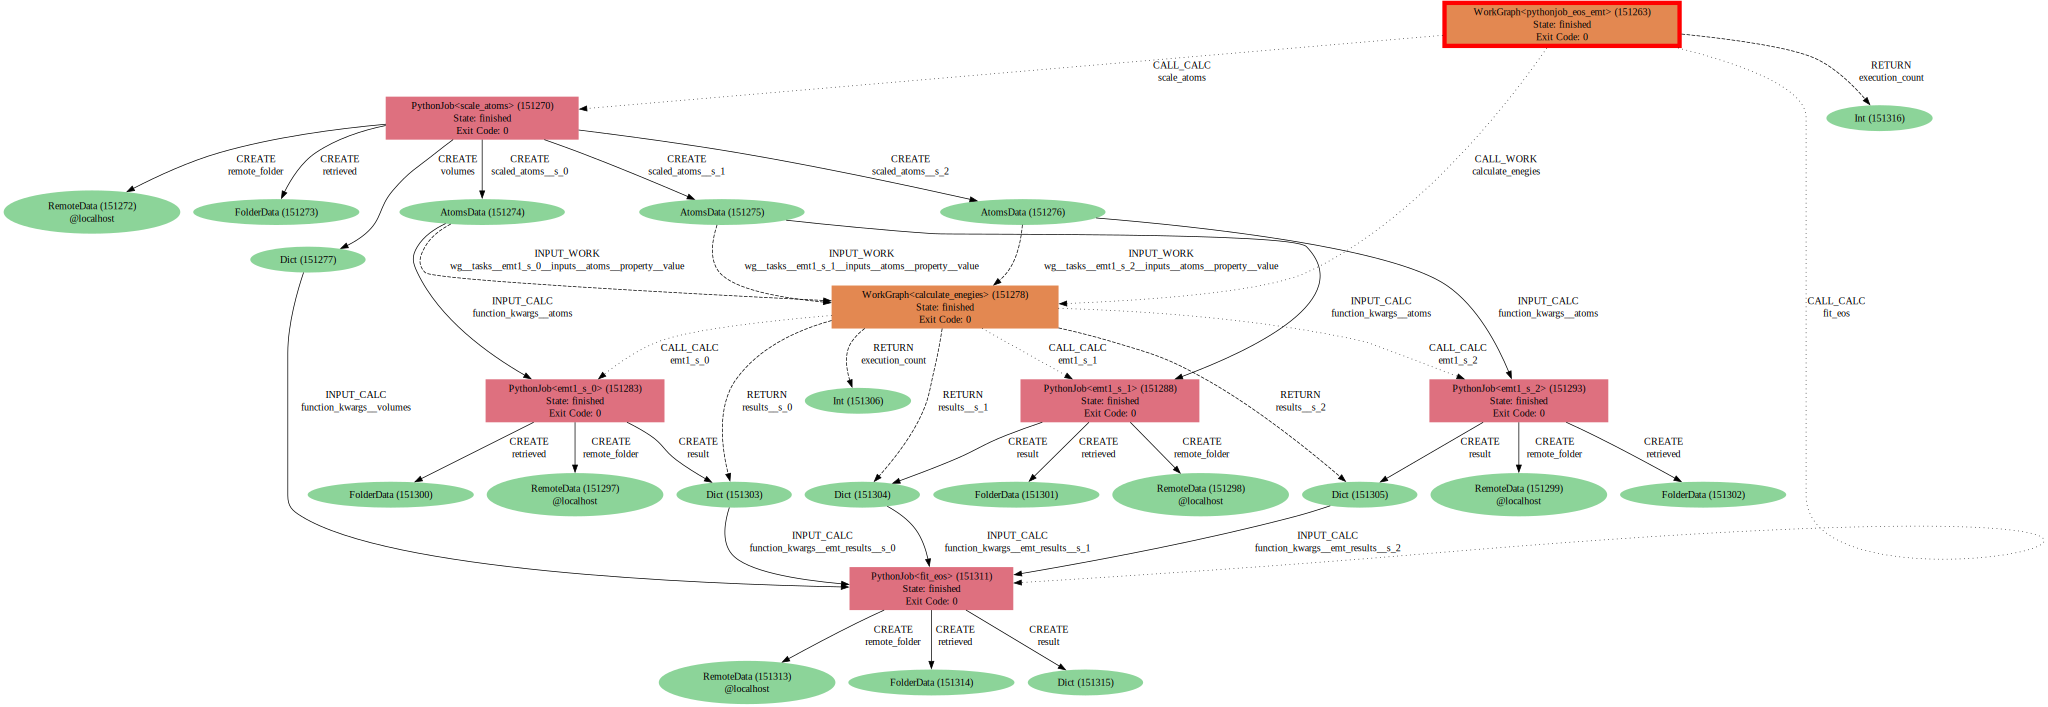

In [17]:
from aiida_workgraph.utils import generate_node_graph

#------------------------- Generate node graph -------------------
generate_node_graph(wg.pk)

## Retrieve additional files from the remote computer
Sometimes, one may want to retrieve additional files from the remote computer after the job has finished. For example, one may want to retrieve the output files generated by the `pw.x` calculation in Quantum ESPRESSO.

One can use the `additional_retrieve_list` parameter to specify which files should be retrieved from the working directory and stored in the local repository after the job has finished

In [18]:
from aiida_workgraph import WorkGraph

def add(x, y):
    z = x + y
    with open("result.txt", "w") as f:
        f.write(str(z))
    return x + y

wg = WorkGraph("test_PythonJob_retrieve_files")
wg.add_task("PythonJob", function=add, name="add")
# ------------------------- Submit the calculation -------------------
wg.submit(
    inputs={
        "add": {
            "x": 2,
            "y": 3,
            "computer": "localhost",
            "metadata": {
                "options": {
                    "additional_retrieve_list": ["result.txt"],
                }
            }
        },
    },
    wait=True,
)

# ------------------------- Print the output -------------------------
filenames = wg.tasks['add'].outputs['retrieved'].value.list_object_names()
print("File in the local repository: ", filenames)

WorkGraph process created, PK: 151317
File in the local repository:  ['_scheduler-stderr.txt', '_scheduler-stdout.txt', 'aiida.out', 'result.txt', 'results.pickle']


We can see that the `result.txt` file is retrieved from the remote computer and stored in the local repository.

## Exit Code

The `PythonJob` task includes a built-in output socket, `exit_code`, which serves as a mechanism for error handling and status reporting during task execution. This `exit_code` is an integer value where `0` indicates a successful completion, and any non-zero value signals that an error occurred.

### How it Works:
When the function returns a dictionary with an `exit_code` key, the system automatically parses and uses this code to indicate the task's status. In the case of an error, the non-zero `exit_code` value helps identify the specific problem.


### Benefits of `exit_code`:

1. **Error Reporting:**  
   If the task encounters an error, the `exit_code` can communicate the reason. This is helpful during process inspection to determine why a task failed.

2. **Error Handling and Recovery:**  
   You can utilize `exit_code` to add specific error handlers for particular exit codes. This allows you to modify the task's parameters and restart it.


Below is an example Python function that uses `exit_code` to handle potential errors:

In [19]:
from aiida_workgraph import WorkGraph, task

@task.pythonjob(outputs=[{"name": "sum"}])
def add(x: int, y: int) -> int:
    sum = x + y
    if sum < 0:
        exit_code = {"status": 410, "message": "Sum is negative"}
        return {"sum": sum, "exit_code": exit_code}
    return {"sum": sum}

wg = WorkGraph("test_PythonJob")
wg.add_task(add, name="add", x=1, y=-2)
wg.submit(wait=True)

print("exit status: ",  wg.tasks["add"].node.exit_status)
print("exit message: ",  wg.tasks["add"].node.exit_message)

WorkGraph process created, PK: 151330
exit status:  410
exit message:  Sum is negative


In this example, the task failed with `exit_code = 410` due to the condition `Sum is negative`, which is also reflected in the state message.

## Error-handling with `exit_code`

One can register error handlers for specific exit codes to handle errors gracefully. This allows for customized error recovery strategies based on the specific error encountered.




In [20]:

def handle_negative_sum(task) -> str:
    """Handle the failure code 410 of the `add`.
    Simply make the inputs positive by taking the absolute value.
    """
    # modify task inputs
    task.set({"x": abs(task.inputs["x"].value),
              "y": abs(task.inputs["y"].value)})
    
    msg = "Run error handler: handle_negative_sum."
    return msg


@task.pythonjob(outputs=[{"name": "sum"}],
                error_handlers=[{"handler": handle_negative_sum,
                                "exit_codes": [410],
                                "max_retries": 5}])
@task.pythonjob(outputs=[{"name": "sum"}])
def add(x: int, y: int) -> int:
    sum = x + y
    if sum < 0:
        exit_code = {"status": 410, "message": "Sum is negative"}
        return {"sum": sum, "exit_code": exit_code}
    return {"sum": sum}

wg = WorkGraph("test_PythonJob")
wg.add_task(add, name="add1", x=1, y=-2, computer="localhost")
wg.submit(wait=True)
print("exit status: ",  wg.tasks["add1"].node.exit_status)
print("exit message: ",  wg.tasks["add1"].node.exit_message)

WorkGraph process created, PK: 151342
exit status:  0
exit message:  None


We can confirm that the task first fails again with a 410. Then the WorkGraph restarts the task with the new inputs, and it finishes successfully. 

In [21]:
%verdi process status {wg.pk}

WorkGraph<test_PythonJob><151342> Finished [0]
    ├── PythonJob<add1><151349> Finished [410]
    └── PythonJob<add1><151360> Finished [0]




## Define your data serializer
Workgraph search data serializer from the `aiida.data` entry point by the module name and class name (e.g., `ase.atoms.Atoms`). 

In order to let the workgraph find the serializer, you must register the AiiDA data with the following format:
```
[project.entry-points."aiida.data"]
abc.ase.atoms.Atoms = "abc.xyz:MyAtomsData"
```
This will register a data serializer for `ase.atoms.Atoms` data. `abc` is the plugin name, module name is `xyz`, and the AiiDA data class name is `AtomsData`. Learn how to create a AiiDA data [here](https://aiida.readthedocs.io/projects/aiida-core/en/stable/topics/data_types.html#adding-support-for-custom-data-types).


### Avoid duplicate data serializer
If you have multiple plugins that register the same data serializer, the workgraph will raise an error. You can avoid this by selecting the plugin that you want to use in the configuration file.

```json
{
    "serializers": {
        "ase.atoms.Atoms": "abc.ase.atoms.Atoms"
    },
}
```

Save the configuration file as `workgraph.json` in the aiida configuration directory (by default, `~/.aiida` directory).


## Use PythonJob outside WorkGraph
One can use the `PythonJob` task outside the WorkGraph to run a Python function on a remote computer. For example, in a `WorkChain` or run a single `CalcJob` calculation.


In [6]:
from aiida import orm, load_profile
from aiida.engine import run_get_node
from aiida_workgraph.calculations.python import PythonJob

load_profile()

python_code = orm.load_code("python3@localhost")

def add(x, y):
    return x + y

result, node = run_get_node(PythonJob, code=python_code,
                            function=add,
                            function_kwargs = {"x": orm.Int(1), "y": orm.Int(2)},
                            function_outputs=[{"name": "add"}])

print("Result: ", result["add"].value)


Result:  3


You can see more details on any process, including its inputs and outputs, using the verdi command:

In [9]:
%verdi process show {node.pk}

Property     Value
-----------  ------------------------------------
type         PythonJob<add>
state        Finished [0]
pk           151415
uuid         ff25998c-98d9-4d56-995a-fe9ecd66468a
label        PythonJob<add>
description
ctime        2024-09-13 10:46:05.231456+02:00
mtime        2024-09-13 10:46:08.263554+02:00
computer     [1] localhost

Inputs            PK      Type
----------------  ------  ---------------
function_kwargs
    x             151412  Int
    y             151413  Int
code              42316   InstalledCode
function          151411  PickledFunction
function_outputs  151414  List

Outputs            PK  Type
-------------  ------  ----------
add            151419  Int
remote_folder  151417  RemoteData
retrieved      151418  FolderData
